In [357]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from copy import deepcopy

In [358]:
# Read historical data
df = pd.read_csv('MSFToneyear.csv')
df



,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-05-24,257.890015,261.329987,253.500000,259.619995,257.134491,29043900
1,2022-05-25,258.140015,264.579987,257.130005,262.519989,260.006714,28547900
2,2022-05-26,262.269989,267.109985,261.429993,265.899994,263.354340,25002100
3,2022-05-27,268.480011,273.339996,267.559998,273.239990,270.624084,26910800
4,2022-05-31,272.529999,274.769989,268.929993,271.869995,269.267181,37827700
...,...,...,...,...,...,...,...
246,2023-05-17,312.290009,314.429993,310.739990,314.000000,314.000000,24315000
247,2023-05-18,314.529999,319.040009,313.720001,318.519989,318.519989,27276000
248,2023-05-19,316.739990,318.750000,316.369995,318.339996,318.339996,27529500
249,2023-05-22,318.600006,322.589996,318.010010,321.179993,321.179993,24115700


In [359]:
df = df[['Date', 'Adj Close']]
df

,Date,Adj Close
0,2022-05-24,257.134491
1,2022-05-25,260.006714
2,2022-05-26,263.354340
3,2022-05-27,270.624084
4,2022-05-31,269.267181
...,...,...
246,2023-05-17,314.000000
247,2023-05-18,318.519989
248,2023-05-19,318.339996
249,2023-05-22,321.179993


In [360]:
# Dates are in object, need to use datetime function to convert it to integer

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2022-05-27')

df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-360-c5d45002fdea>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0     2022-05-24
1     2022-05-25
2     2022-05-26
3     2022-05-27
4     2022-05-31
         ...    
246   2023-05-17
247   2023-05-18
248   2023-05-19
249   2023-05-22
250   2023-05-23
Name: Date, Length: 251, dtype: datetime64[ns]

In [361]:
# We want to remove the first column to make the date start at 0

df.index = df.pop('Date')
df.head()

,Adj Close
Date,
2022-05-24,257.134491
2022-05-25,260.006714
2022-05-26,263.354340
2022-05-27,270.624084
2022-05-31,269.267181


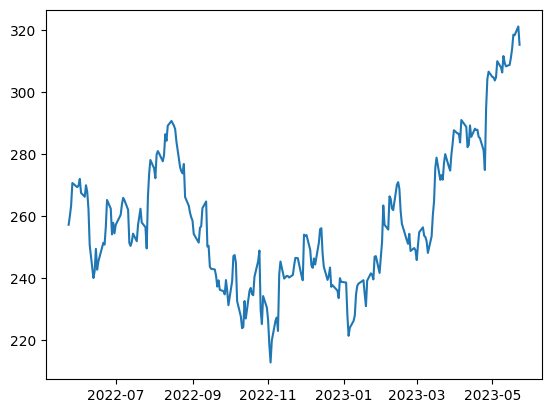

In [362]:
plt.plot(df.index, df['Adj Close'])

In [363]:
# Create dataframe to find if the previous days return was positive (1) or negative (0) looped through three consecutive days as n=3

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return
        
        values = df_subset['Adj Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)
        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target - {n-i}'] = X[:, i]
    
    ret_df['Target'] = Y

    return ret_df

windowed_df = df_to_windowed_df(df,
    '2022-05-27',
    '2023-05-23',
    n=3)

windowed_df


,Target Date,Target - 3,Target - 2,Target - 1,Target
0,2022-05-27,257.134491,260.006714,263.354340,270.624084
1,2022-05-31,260.006714,263.354340,270.624084,269.267181
2,2022-06-01,263.354340,270.624084,269.267181,269.811951
3,2022-06-02,270.624084,269.267181,269.811951,271.951233
4,2022-06-03,269.267181,269.811951,271.951233,267.434937
...,...,...,...,...,...
243,2023-05-17,308.296051,308.784973,311.059998,314.000000
244,2023-05-18,308.784973,311.059998,314.000000,318.519989
245,2023-05-19,311.059998,314.000000,318.519989,318.339996
246,2023-05-22,314.000000,318.519989,318.339996,321.179993


In [364]:
# Reshape dataframe for numpy analysis

def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]

    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape


((248,), (248, 3, 1), (248,))

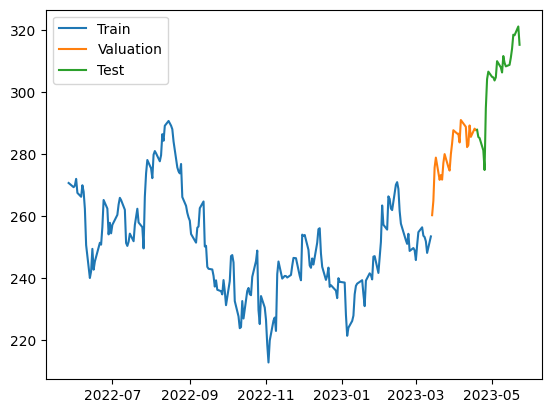

In [365]:
# pick percentage of dates to train 80,90

q_80 = int(len(dates) * 0.80)
q_90 = int(len(dates) * 0.90)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Valuation', 'Test'])

In [366]:
# Time to train

model = Sequential([layers.Input((3,1)),
                    layers.LSTM(72),
                    layers.Dense(72, activation='relu'),
                    layers.Dense(72, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
               optimizer=Adam(learning_rate=0.001),
               metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500)

Epoch 1/500
7/7 [==============================] - 3s 106ms/step - loss: 62904.0312 - mean_absolute_error: 250.2936 - val_loss: 78173.4062 - val_mean_absolute_error: 279.4875
Epoch 2/500
7/7 [==============================] - 0s 11ms/step - loss: 62557.4102 - mean_absolute_error: 249.6005 - val_loss: 77778.3516 - val_mean_absolute_error: 278.7799
Epoch 3/500
7/7 [==============================] - 0s 14ms/step - loss: 62177.5508 - mean_absolute_error: 248.8398 - val_loss: 77278.3359 - val_mean_absolute_error: 277.8817
Epoch 4/500
7/7 [==============================] - 0s 11ms/step - loss: 61677.1055 - mean_absolute_error: 247.8329 - val_loss: 76618.0469 - val_mean_absolute_error: 276.6909
Epoch 5/500
7/7 [==============================] - 0s 10ms/step - loss: 60977.7422 - mean_absolute_error: 246.4147 - val_loss: 75566.0938 - val_mean_absolute_error: 274.7831
Epoch 6/500
7/7 [==============================] - 0s 13ms/step - loss: 59842.7422 - mean_absolute_error: 244.0985 - val_loss: 74

7/7 [==============================] - 1s 3ms/step


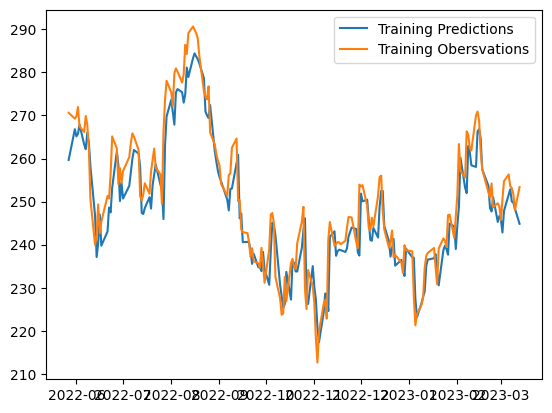

In [367]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Obersvations'])

1/1 [==============================] - 0s 24ms/step


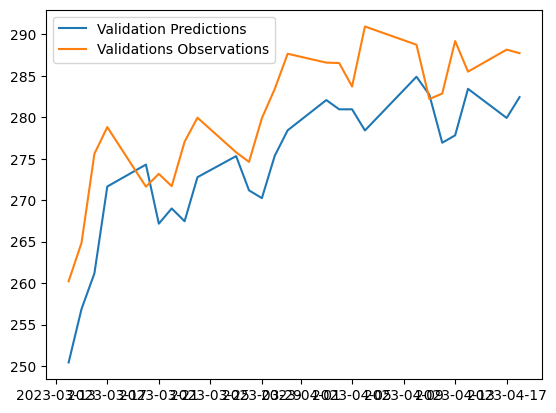

In [368]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validations Observations'])

1/1 [==============================] - 0s 28ms/step


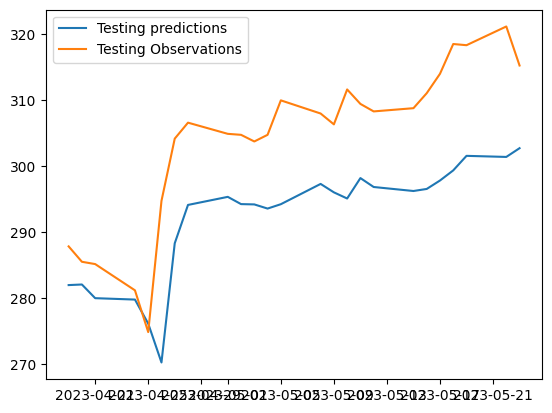

In [369]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing predictions', 'Testing Observations'])

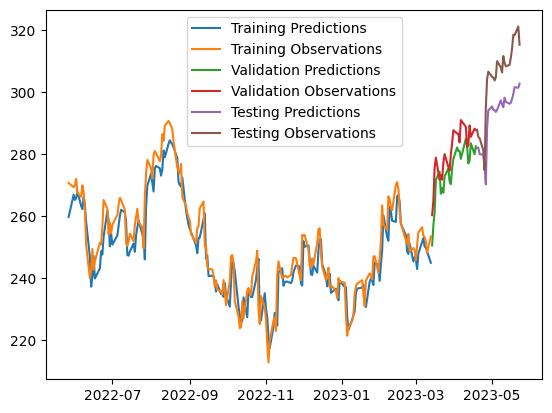

In [370]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

1/1 [==============================] - 0s 38ms/step


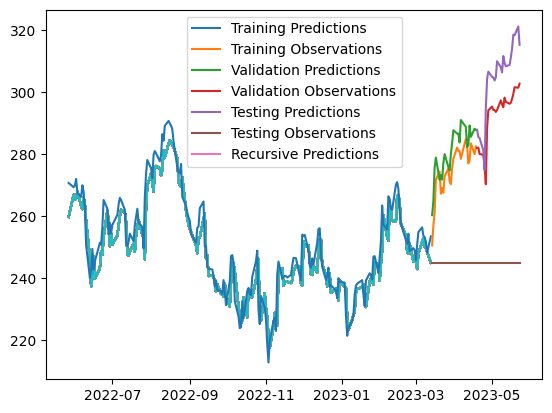

In [371]:
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])
 
for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

  plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])